In [7]:
%matplotlib inline
import os

import ase.io
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import mpltex
import numpy as np
import scipy
from ase import Atoms
from ase.io import aims, write
from ase.visualize import view
from scipy.spatial import distance_matrix
from tqdm.auto import tqdm

ModuleNotFoundError: No module named 'mpltex'

In [2]:
def plot(fname=None, show_trimer=True, subplotlabels="ab"):
    if show_trimer:
        n_ax = 2
    else:
        n_ax = 1

    fig, ax = plt.subplots(n_ax, sharex=True, dpi=200)

    if not show_trimer:
        ax = [ax]

    step = 2

    for a in ax:
        a.axhline(0, ls="dashed", c="gray")
        a.ticklabel_format(axis="y", style="sci", scilimits=(-2, -2))
        a.minorticks_on()

    ax[0].axvline(
        training_cutoff, c="green", label=(not show_trimer) * "$r_\mathrm{train}$"
    )
    ax[0].plot(
        distances_dimers[::step],
        energies_dimers[::step],
        "s",
        markerfacecolor="None",
        label="dimer ref.",
        c="blue",
    )

    ax[0].plot(
        distances_dimers,
        y_pred_dimers,
        label="dimer pred.",
        c="blue",
    )

    if show_trimer:
        ax[0].plot(
            distances_trimers,
            energies_trimers[:50],
            "s",
            markerfacecolor="None",
            label="trimer ref.",
            c="red",
        )

        ax[0].plot(
            distances_trimers,
            y_pred_trimers[:50],
            c="red",
            label="trimer pred.",
        )

    ax[0].set_xlim(3.3, 14)
    ax[0].axhline(0, ls="dashed", c="gray")

    if show_trimer:
        ax[1].axvline(training_cutoff, c="green", label="$r_\mathrm{train}$")
        ax[1].plot(
            distances_trimers[::step],
            energies_trimers[:50:step] - energies_trimers_drimers[:50:step],
            "s",
            markerfacecolor="None",
            label="ref.",
            c="k",
        )
        ax[1].plot(
            distances_trimers,
            y_pred_trimers[:50] - y_dimer_trimer[:50],
            label="pred.",
            c="k",
        )

        ax[1].set_ylim(-0.6e-2, 0.4e-2)
        ax[1].legend(
            ncol=3, handlelength=1, columnspacing=0.5, frameon=True, edgecolor="None"
        )

    ax[-1].set_xlabel("d / Å")
    ax[-1].set_ylabel("$E_\mathrm{trimer} - 3E_\mathrm{dimer}$ / eV")

    ax[0].set_ylim(-8e-2, 11e-2)
    ax[0].legend(
        ncol=2, handlelength=1, columnspacing=0.5, frameon=True, edgecolor="None"
    )
    ax[0].set_ylabel("$E$ / eV")

    fig.align_labels()

    if fname is not None:
        fig.savefig(fname, bbox_inches="tight", transparent=False)

In [3]:
def calc_dimer_trimer_energies(frames, energy_inter):
    dimer_trimer_energies = np.zeros(len(frames))

    for i, atoms in enumerate(frames):
        dist_mat = distance_matrix(atoms.positions, atoms.positions)
        #print(dist_mat)
        pair_distances = dist_mat[np.triu_indices(len(atoms), k=1)]
        # if np.isnan(pair_distances):
        pred_dimer = energy_inter(pair_distances)
        #print(pred_dimer)
        pred_dimer[np.isnan(pred_dimer)] = energy_inter(14)
        dimer_trimer_energies[i] = np.sum(pred_dimer)
        #if np.isnan(dimer_trimer_energies[i]):
            #print(pred_dimer)

    return dimer_trimer_energies

In [4]:
def split(X, y, idx_train, idx_test):

    samples_train = metatensor.Labels(["structure"], idx_train)
    samples_test = metatensor.Labels(["structure"], idx_test)

    split_args = {
        "axis": "samples",
        "grouped_labels": [
            samples_train,
            samples_test,
        ],
    }

    X_train, X_test = metatensor.split(X, **split_args)
    y_train, y_test = metatensor.split(y, **split_args)

    return X_train, X_test, y_train, y_test

In [5]:
def show(dataset):
    import chemiscope
    chemiscope.show(dataset, mode="structure")

In [6]:
def get_train_test(mask):

    train_frames_dataset = []
    test_frames_dataset = []
    for idx in range(len(mask)):
        if mask[idx]:
            train_frames_dataset.append(idx)
        else:
            test_frames_dataset.append(idx)
    train_frames_dataset = np.array(train_frames_dataset)
    test_frames_dataset = np.array(test_frames_dataset)

    return train_frames_dataset, test_frames_dataset

# Load dft results

In [57]:
ori_frames_datasets = ase.io.read("xe3_dataset_dft.xyz", ":")
frames_datasets = ori_frames_datasets#[]
#for atoms in ori_frames_datasets:
#    dist_mat = distance_matrix(atoms.positions, atoms.positions)
#    if np.all(dist_mat <= 14):
#        frames_datasets.append(atoms)
dimer_datasets = frames_datasets[:50]
trimer_datasets = frames_datasets[50:100]
random_trimer_datasets = frames_datasets[100:]
n_total_random = len(random_trimer_datasets)

In [58]:
d = []
for i, atoms in enumerate(random_trimer_datasets):
    dist_mat = distance_matrix(atoms.positions, atoms.positions)
    #print(dist_mat)
    pair_distances = dist_mat[np.triu_indices(len(atoms), k=1)]
    d.append(pair_distances)
d = np.concatenate(d)

(array([3420., 3417., 3810., 3707., 1936.,  738.,  490.,  323.,  129.,
          30.]),
 array([ 2.5 ,  4.25,  6.  ,  7.75,  9.5 , 11.25, 13.  , 14.75, 16.5 ,
        18.25, 20.  ]),
 <BarContainer object of 10 artists>)

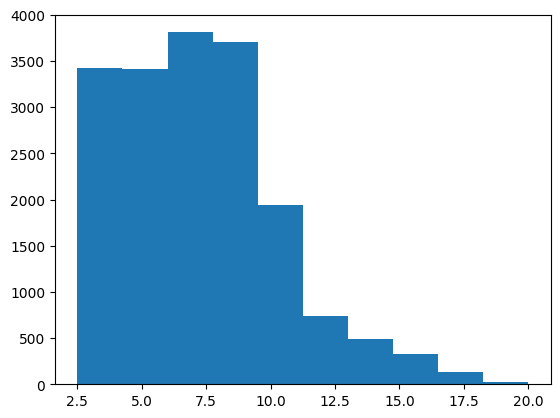

In [59]:
plt.hist(d)

In [60]:
import chemiscope
chemiscope.show(random_trimer_datasets, mode="structure")

StructureWidget(value='{"meta": {"name": " "}, "structures": [{"size": 3, "names": ["Xe", "Xe", "Xe"], "x": [0…

In [61]:
n_dimer = 40
n_trimer = 40
dimer_idx = np.random.choice(list(range(50)), n_dimer, replace=False)
trimer_idx = np.random.choice(list(range(50, 100)), n_trimer, replace=False)
#dimer_idx = np.arange(n_dimer)
#trimer_idx = np.arange(50, n_trimer + 50)

In [62]:
# Find where Xenon3 starts
#for i, atoms in enumerate(frames_dataset):
#    if len(atoms) == 3:
#        split = i
#        break

# Holds codes dealing with dimer and equilateral trimer energy

distances_dimers = np.array(
    [atoms.info["distance"] for atoms in dimer_datasets]
)
energies_dimers = np.array([atoms.info["energy"] for atoms in dimer_datasets])

distances_trimers = np.array(
    [atoms.info["distance"] for atoms in trimer_datasets]
)
energies_trimers = np.array([atoms.info["energy"] for atoms in trimer_datasets])

energies_random_trimers = np.array([atoms.info["energy"] for atoms in random_trimer_datasets])

dimer_energy_inter = scipy.interpolate.CubicSpline(
    distances_dimers, energies_dimers.copy(), extrapolate=False
)

energies_trimers_drimers = calc_dimer_trimer_energies(
    trimer_datasets, dimer_energy_inter
)

trimer_zero_point = energies_trimers[-1]
diff_zero_point = energies_trimers_drimers[-1]
energies_dimers -= energies_dimers[-1]
energies_trimers -= trimer_zero_point
energies_trimers_drimers -= diff_zero_point

In [63]:
ratio = 0.01
n_random_trimer = int(n_total_random * ratio)
random_trimer_idx = np.random.choice(list(range(100, 100 + len(random_trimer_datasets))), n_random_trimer, replace=False)
mask = np.full(len(frames_datasets), False)
mask[dimer_idx] = True
mask[trimer_idx] = True
mask[random_trimer_idx] = True

In [64]:
train_frames_dataset, test_frames_dataset = get_train_test(mask)

In [65]:
energies_random_trimers_dimers = calc_dimer_trimer_energies(
    random_trimer_datasets, dimer_energy_inter
)

energies_random_trimers -= trimer_zero_point
energies_random_trimers_dimers -= diff_zero_point

# Plot

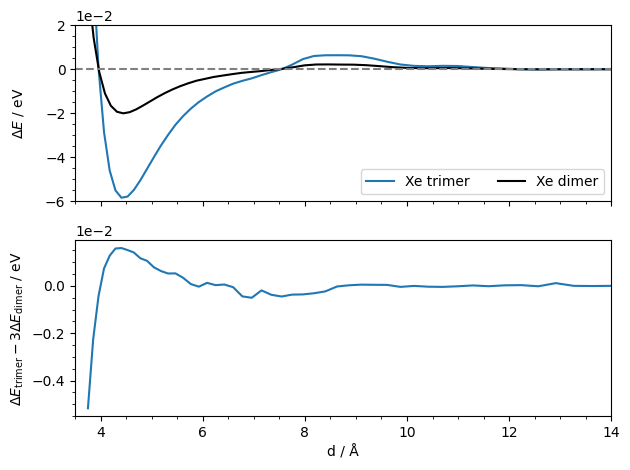

In [66]:
fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(
    distances_trimers,
    energies_trimers,
    label="Xe trimer"
)
ax[1].plot(
    distances_trimers,
    energies_trimers - energies_trimers_drimers,
    "-",
)

ax[0].plot(
    distances_dimers,
    energies_dimers,
    "-",
    label=f"Xe dimer",
    c="k",
    markerfacecolor="None",
)

ax[0].axhline(0, ls="dashed", c="gray")
ax[0].legend(ncol=3)

ax[-1].set_xlabel("d / Å")

ax[0].set_ylim(-6e-2, 2e-2)
ax[1].set_xlim(3.5, 14)

for a in ax:
    #a.axhline(0, ls="dashed", c="gray")
    a.ticklabel_format(axis="y", style="sci", scilimits=(-2, -2))
    a.minorticks_on()

# ax[1].set_ylim(-1e-2, 4e-2)

ax[0].set_ylabel("$\Delta E$ / eV")
ax[1].set_ylabel("$\Delta E_\mathrm{trimer} - 3\Delta E_\mathrm{dimer}$ / eV")

fig.align_labels()
fig.tight_layout()

fig.savefig("figures/xe_energies.png", bbox_inches="tight", transparent=False)

# Train Model

### Generate descriptor

In [67]:
import metatensor
from equisolve.utils.convert import ase_to_tensormap
from rascaline import AtomicComposition, LodeSphericalExpansion
from rascaline.utils import PowerSpectrum
from radial_basis import KspaceRadialBasis
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

In [68]:
cutoff = 3.0
max_radial = 6
max_angular = 4
atomic_gaussian_width = 1.0
radial_basis = "monomial_spherical"

lr_hypers_rs = {
    "cutoff": cutoff,
    "max_radial": max_radial,
    "max_angular": 0,
    "atomic_gaussian_width": atomic_gaussian_width,
    "center_atom_weight": 1.0,
    "potential_exponent": 6,
    "radial_basis": {radial_basis: {}},
}

lr_hypers_ps = {
    "cutoff": 3.0,
    "max_radial": max_radial,
    "max_angular": max_angular,
    "atomic_gaussian_width": atomic_gaussian_width,
    "center_atom_weight": 1.0,
    "potential_exponent": 4,
    "radial_basis": {radial_basis: {}},
}

In [69]:
orthonormalization_radius = cutoff
k_cut = 1.2 * np.pi / atomic_gaussian_width

rad_rs = KspaceRadialBasis(
    radial_basis,
    max_radial=max_radial,
    max_angular=0,
    projection_radius=cutoff,
    orthonormalization_radius=orthonormalization_radius,
)

lr_hypers_rs["radial_basis"] = rad_rs.spline_points(
    cutoff_radius=k_cut, requested_accuracy=1e-8
)

rad_ps = KspaceRadialBasis(
    radial_basis,
    max_radial=max_radial,
    max_angular=max_angular,
    projection_radius=cutoff,
    orthonormalization_radius=orthonormalization_radius,
)

lr_hypers_ps["radial_basis"] = rad_ps.spline_points(
    cutoff_radius=k_cut, requested_accuracy=1e-8
)

In [70]:
rs_calculator = LodeSphericalExpansion(**lr_hypers_rs)

co_calculator = AtomicComposition(per_structure=True)

ps_calculator = PowerSpectrum(
    LodeSphericalExpansion(**lr_hypers_ps),
    LodeSphericalExpansion(**lr_hypers_ps),
)

In [71]:
training_cutoff = 7.5
rs_ps = True  # Use a rs and a ps or only a rs

In [72]:
frames_fit = frames_datasets

In [73]:
descriptor_rs = rs_calculator.compute(frames_fit)
descriptor_rs = descriptor_rs.components_to_properties(["spherical_harmonics_m"])
descriptor_rs = descriptor_rs.keys_to_properties(
    ["species_neighbor", "spherical_harmonics_l"]
)
descriptor_rs = descriptor_rs.keys_to_samples(["species_center"])
descriptor_rs = metatensor.sum_over_samples(
    descriptor_rs, sample_names=["center", "species_center"]
)

descriptor_ps = ps_calculator.compute(frames_fit)
descriptor_ps = descriptor_ps.keys_to_samples(["species_center"])
descriptor_ps = metatensor.sum_over_samples(
    descriptor_ps, sample_names=["center", "species_center"]
)

descriptor_co = co_calculator.compute(frames_fit)
descriptor_co = descriptor_co.keys_to_properties("species_center")

In [74]:
if rs_ps:
    X = metatensor.join([descriptor_rs, descriptor_ps], axis="properties")
else:
    X = metatensor.join([descriptor_rs], axis="properties")

y = ase_to_tensormap(frames_fit, energy="energy")
X[0].values[y[0].values.flatten() > -600000, :] /= 2
X[0].values[y[0].values.flatten() < -600000, :] /= 3

In [75]:
X[0].values.shape

(6100, 186)

(array([13., 33.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([-205862.79108646, -205862.78411001, -205862.77713357,
        -205862.77015713, -205862.76318069, -205862.75620425,
        -205862.74922781, -205862.74225137, -205862.73527493,
        -205862.72829849, -205862.72132205]),
 <BarContainer object of 10 artists>)

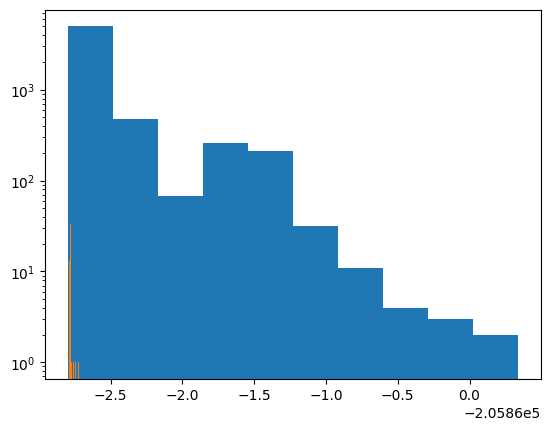

In [105]:
plt.hist(y[0].values.flatten()[y[0].values.flatten()< -600000] / 3, log=True)
plt.hist(y[0].values.flatten()[y[0].values.flatten()> -600000] / 2, log=True)

(array([13., 33.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([-411725.58217291, -411725.56822003, -411725.55426715,
        -411725.54031427, -411725.52636138, -411725.5124085 ,
        -411725.49845562, -411725.48450274, -411725.47054986,
        -411725.45659698, -411725.4426441 ]),
 <BarContainer object of 10 artists>)

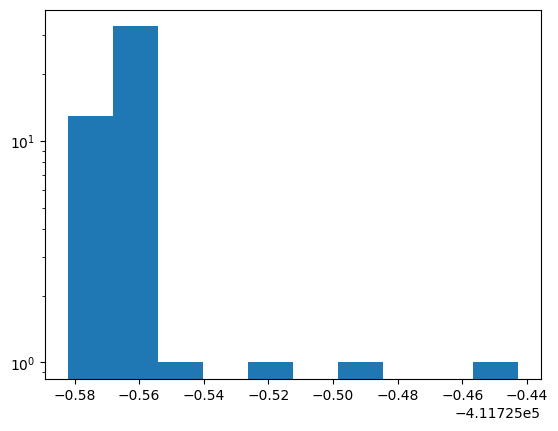

In [77]:
plt.hist(y[0].values.flatten()[y[0].values.flatten()> -600000], log=True)

### Train

In [27]:
#ratio = 0.8
#train_split = int(ratio * X[0].values.shape[0])
#train_split = 700
#idx_train = np.arange(train_split)[np.newaxis, :].T
#idx_test = np.arange(train_split, X[0].values.shape[0])[np.newaxis, :].T



#for i, atoms in enumerate(frames_fit):
#    delta_distance = atoms.info["distance"]
#    if delta_distance <= training_cutoff:
#        idx_train += [[i]]
#    else:
#        idx_test += [[i]]
#
#idx_train = np.array(idx_train)
#idx_test = np.array(idx_test)
idx_train = np.array(train_frames_dataset)[np.newaxis, :].T
idx_test = np.array(test_frames_dataset)[np.newaxis, :].T
X_train, X_test, y_train, y_test = split(X, y, idx_train, idx_test)

#### Baselining

In [28]:
# COMPOSITION BASELINING
# Only baseline if we have dimers and trimers
rcv = RidgeCV(alphas=np.geomspace(1e-18, 1e2, 14), fit_intercept=False)
rcv.fit(descriptor_co[0].values, y[0].values)
print(rcv.alpha_)
yp_base = rcv.predict(descriptor_co[0].values).flatten()

1.7012542798525926e-09


In [29]:
y_diff = y[0].values.flatten() - yp_base
y_diff_train = y_diff[idx_train].flatten()

(array([6050.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          50.]),
 array([-617588.4016012 , -597002.10570549, -576415.80980978,
        -555829.51391407, -535243.21801836, -514656.92212265,
        -494070.62622694, -473484.33033123, -452898.03443552,
        -432311.73853981, -411725.4426441 ]),
 <BarContainer object of 10 artists>)

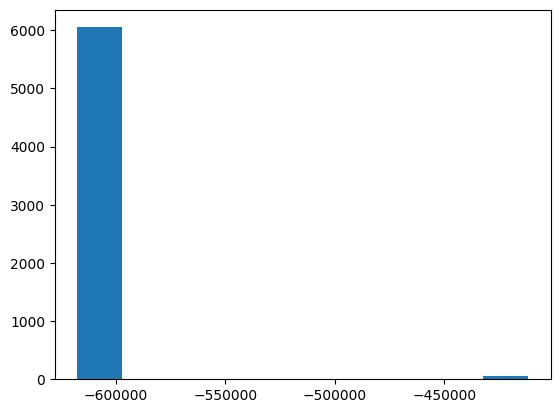

In [104]:
plt.hist(y[0].values.flatten())

(array([5372.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          50.]),
 array([-613825.3125 , -593364.46875, -572903.625  , -552442.78125,
        -531981.9375 , -511521.09375, -491060.25   , -470599.40625,
        -450138.5625 , -429677.71875, -409216.875  ]),
 <BarContainer object of 10 artists>)

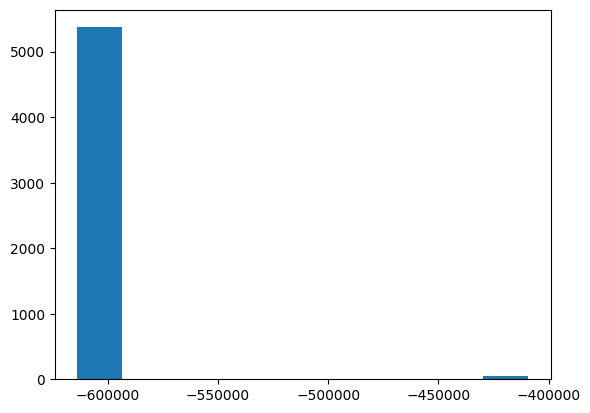

In [103]:
plt.hist(yp_base)

(array([13., 33.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([-2508.70717291, -2508.69322003, -2508.67926715, -2508.66531427,
        -2508.65136138, -2508.6374085 , -2508.62345562, -2508.60950274,
        -2508.59554986, -2508.58159698, -2508.5676441 ]),
 <BarContainer object of 10 artists>)

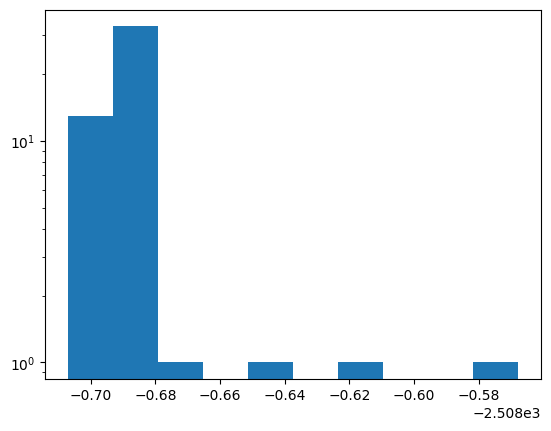

In [34]:
plt.hist(y_diff[y_diff> -3000], log=True)

(array([4.309e+03, 4.730e+02, 6.800e+01, 2.600e+02, 2.100e+02, 3.200e+01,
        1.100e+01, 4.000e+00, 3.000e+00, 2.000e+00]),
 array([-3763.0891012 , -3762.14657755, -3761.2040539 , -3760.26153025,
        -3759.3190066 , -3758.37648296, -3757.43395931, -3756.49143566,
        -3755.54891201, -3754.60638836, -3753.66386471]),
 <BarContainer object of 10 artists>)

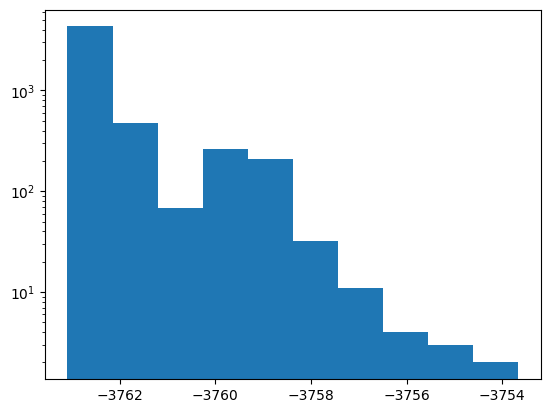

In [36]:
plt.hist(y_diff[y_diff< -3000], log=True)

In [35]:
y_diff[y_diff< -3000]

array([-3762.9187885 , -3762.98513566, -3763.03020242, ...,
       -3763.0350645 , -3763.05541866, -3763.01823449])

#### Real train

In [26]:
y_train[0].values[y_train[0].values > -600000] /= 2
y_train[0].values[y_train[0].values < -600000] /= 3
#y_train[y_train > -600000] /= 2
#y_train[y_train < -600000] /= 3

In [27]:
# if we baseline the energies we should not have to fit the intercept
clf = RidgeCV(alphas=np.geomspace(1e-12, 1e2, 32), fit_intercept=True)
clf.fit(X_train[0].values, y_train[0].values.flatten())
#clf.fit(X_train, y_train)
#clf.fit(X_train[0].values, y_diff_train)
print(clf.alpha_)

y_diff_pred = clf.predict(X[0].values).flatten()
y_pred = np.copy(y_diff_pred)
y_pred[:50] *= 2
y_pred[50:] *= 3
#y_pred = y_diff_pred.copy() + yp_base

2.2638034095214513e-11


In [28]:
y_pred_dimers = y_pred[:50]
y_pred_trimers = y_pred[50:]

y_pred_inter = scipy.interpolate.CubicSpline(
    distances_dimers, y_pred_dimers, extrapolate=False
)
y_pred_dimers -= y_pred_dimers[-1]
y_pred_trimers -= y_pred_trimers[49]
y_dimer_trimer = calc_dimer_trimer_energies(frames_datasets[50:], y_pred_inter)
y_dimer_trimer -= y_dimer_trimer[49]

In [29]:
rmse_dimer = mean_squared_error(
    y_pred_dimers[np.array(test_frames_dataset)[:50 - n_dimer]], 
    energies_dimers[np.array(test_frames_dataset)[:50 - n_dimer]], squared=False
) / np.std(y_pred_dimers[train_frames_dataset[:n_dimer]])

rmse_trimer = mean_squared_error(
    y_pred_trimers[np.array(test_frames_dataset)[50 - n_trimer:] - 50], 
    np.concatenate([energies_trimers, energies_random_trimers])[np.array(test_frames_dataset)[50 - n_trimer:] - 50], squared=False
) / np.std(np.concatenate([y_pred_dimers, y_pred_trimers])[train_frames_dataset])

rmse_diff = mean_squared_error(
    np.concatenate([energies_trimers, energies_random_trimers]) - np.concatenate([energies_trimers_drimers, energies_random_trimers_dimers]), 
    y_pred_trimers - y_dimer_trimer, squared=False
) / np.std((y_pred_trimers - y_dimer_trimer)[np.array(train_frames_dataset)[50 - n_dimer:] - 50])

(array([2.00e+00, 6.00e+00, 1.40e+01, 5.50e+01, 5.19e+03, 1.60e+01,
        3.00e+00, 1.00e+00, 1.00e+00, 1.00e+00]),
 array([-0.61517791, -0.48056135, -0.34594479, -0.21132823, -0.07671167,
         0.05790489,  0.19252144,  0.327138  ,  0.46175456,  0.59637112,
         0.73098768]),
 <BarContainer object of 10 artists>)

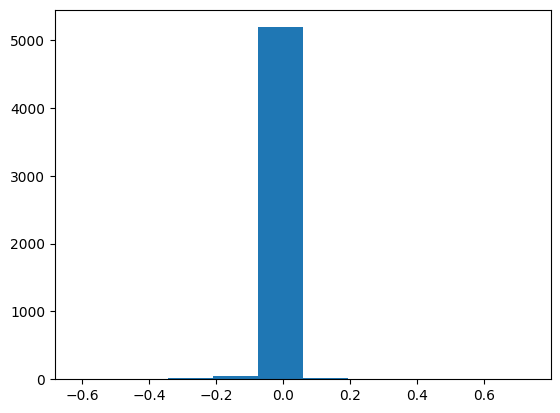

In [30]:
plt.hist(np.concatenate([energies_trimers, energies_random_trimers])[idx_test - 50] - y_pred_trimers[idx_test - 50])

In [78]:
outname_suffix = f"dimers{'+trimers'*True}_rs{'+ps'*rs_ps}"

if rs_ps:
    subplotlabels = "cd"
else:
    subplotlabels = "ab"

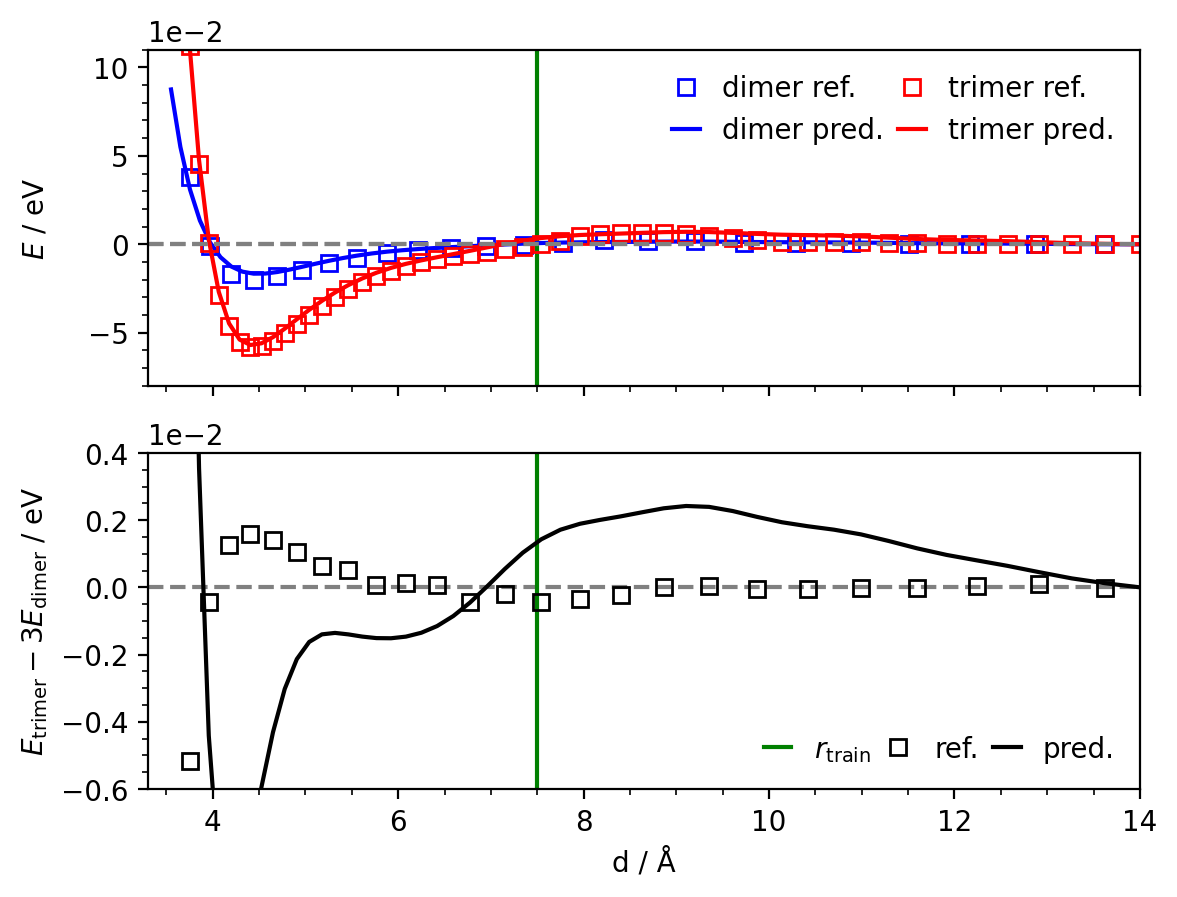

In [32]:
plot(f"figures/xe_{outname_suffix}.pdf", show_trimer=True, subplotlabels=subplotlabels)

# Developing

In [91]:
from sklearn.neural_network import MLPRegressor

/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 2118974613199.68359375
Iteration 2, loss = 2096376350280.94067383
Iteration 3, loss = 2044970567199.60498047
Iteration 4, loss = 1987407236564.50146484
Iteration 5, loss = 1927668238154.10009766
Iteration 6, loss = 1867204251288.41015625
Iteration 7, loss = 1806717143931.73120117
Iteration 8, loss = 1746604557556.52734375
Iteration 9, loss = 1687116044981.44848633
Iteration 10, loss = 1628419820760.33154297
Iteration 11, loss = 1570635295208.65698242
Iteration 12, loss = 1513850506131.59863281
Iteration 13, loss = 1458132156396.32958984
Iteration 14, loss = 1403531732644.04833984
Iteration 15, loss = 1350089412732.74145508
Iteration 16, loss = 1297836660504.53906250
Iteration 17, loss = 1246798008026.83569336
Iteration 18, loss = 1196992317003.92480469
Iteration 19, loss = 1148433696337.88623047
Iteration 20, loss = 1101132186902.26757812
Iteration 21, loss = 1055094285282.30139160
Iteration 22, loss = 1010323354019.14160156
Iteration 23, loss = 966819950545.8775634

/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_655657/2043917285.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_dimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_trimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_diff = mean_squared_error(


ratio=0.0 rmse_dimer=inf rmse_trimer=inf rmse_diff=inf


/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 2090440464271.90039062
Iteration 2, loss = 1876711989088.67016602
Iteration 3, loss = 1638346088138.82495117
Iteration 4, loss = 1413247959608.73022461
Iteration 5, loss = 1206278111171.78320312
Iteration 6, loss = 1019076846136.16943359
Iteration 7, loss = 852051238426.67321777
Iteration 8, loss = 704902988298.79516602
Iteration 9, loss = 576854277037.70678711
Iteration 10, loss = 466784494347.58502197
Iteration 11, loss = 373332912921.28979492
Iteration 12, loss = 294983801383.93408203
Iteration 13, loss = 230139117524.94149780
Iteration 14, loss = 177180384746.78280640
Iteration 15, loss = 134520206777.91870117
Iteration 16, loss = 100643691435.76618958
Iteration 17, loss = 74140157456.87033081
Iteration 18, loss = 53725505515.77668762
Iteration 19, loss = 38255913308.54849243
Iteration 20, loss = 26733796874.73085785
Iteration 21, loss = 18307048083.12709808
Iteration 22, loss = 12262788443.79077148
Iteration 23, loss = 8016973411.65227509
Iteration 24, loss = 5

/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_655657/2043917285.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_dimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_trimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_diff = mean_squared_error(


ratio=0.1 rmse_dimer=inf rmse_trimer=inf rmse_diff=inf


/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 2010241188962.99340820
Iteration 2, loss = 1607278564898.33886719
Iteration 3, loss = 1229631624534.80761719
Iteration 4, loss = 911200247109.64196777
Iteration 5, loss = 653815385002.57836914
Iteration 6, loss = 453533918668.09197998
Iteration 7, loss = 303476348362.36248779
Iteration 8, loss = 195353491307.67095947
Iteration 9, loss = 120580050866.43624878
Iteration 10, loss = 71082647467.04513550
Iteration 11, loss = 39824530186.54933167
Iteration 12, loss = 21071498552.85285950
Iteration 13, loss = 10440184024.01552963
Iteration 14, loss = 4785542408.29531670
Iteration 15, loss = 1992216266.17069745
Iteration 16, loss = 730340030.71905541
Iteration 17, loss = 222389803.85713536
Iteration 18, loss = 49126899.74211709
Iteration 19, loss = 4984291.09721669
Iteration 20, loss = 607880.96713905
Iteration 21, loss = 3356275.41468095
Iteration 22, loss = 4618444.74772403
Iteration 23, loss = 3954364.12083858
Iteration 24, loss = 2581996.85899351
Iteration 25, loss = 13

/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_655657/2043917285.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_dimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_trimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_diff = mean_squared_error(


ratio=0.2 rmse_dimer=inf rmse_trimer=inf rmse_diff=inf


/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1927585064130.31469727
Iteration 2, loss = 1363123717585.93188477
Iteration 3, loss = 895524499910.57543945
Iteration 4, loss = 550881941621.98315430
Iteration 5, loss = 315747447865.15124512
Iteration 6, loss = 167393447614.52020264
Iteration 7, loss = 81295042579.61016846
Iteration 8, loss = 35706467500.26564789
Iteration 9, loss = 13929077786.50279617
Iteration 10, loss = 4692177109.46866703
Iteration 11, loss = 1298839072.69749331
Iteration 12, loss = 266022643.48097157
Iteration 13, loss = 29798719.31149625
Iteration 14, loss = 727694.80779150
Iteration 15, loss = 3594311.27701502
Iteration 16, loss = 4250916.15191701
Iteration 17, loss = 2504320.20910381
Iteration 18, loss = 956029.89685888
Iteration 19, loss = 235767.04842186
Iteration 20, loss = 29006.12531765
Iteration 21, loss = 731.08531690
Iteration 22, loss = 3431.49039964
Iteration 23, loss = 3625.09482560
Iteration 24, loss = 1745.56157990
Iteration 25, loss = 468.98389717
Iteration 26, loss = 58.8512

/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_655657/2043917285.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_dimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_trimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_diff = mean_squared_error(


ratio=0.30000000000000004 rmse_dimer=inf rmse_trimer=inf rmse_diff=inf


/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1829542114020.83911133
Iteration 2, loss = 1130650783967.89624023
Iteration 3, loss = 621817264473.20031738
Iteration 4, loss = 303999770922.67443848
Iteration 5, loss = 130061499313.77761841
Iteration 6, loss = 47601752130.44384766
Iteration 7, loss = 14405866109.25127029
Iteration 8, loss = 3401068716.99474144
Iteration 9, loss = 553649695.05710280
Iteration 10, loss = 42806614.43291277
Iteration 11, loss = 1249103.33607211
Iteration 12, loss = 4572741.02212443
Iteration 13, loss = 2973181.37383944
Iteration 14, loss = 876477.66580732
Iteration 15, loss = 119763.49209822
Iteration 16, loss = 3184.79500602
Iteration 17, loss = 3672.07379682
Iteration 18, loss = 3198.02306733
Iteration 19, loss = 874.35342365
Iteration 20, loss = 80.15762249
Iteration 21, loss = 11.69849537
Iteration 22, loss = 17.76417726
Iteration 23, loss = 11.21005294
Iteration 24, loss = 7.72112071
Iteration 25, loss = 7.37114506
Iteration 26, loss = 7.38565535
Iteration 27, loss = 7.35422907
I

/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_655657/2043917285.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_dimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_trimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_diff = mean_squared_error(


ratio=0.4 rmse_dimer=inf rmse_trimer=inf rmse_diff=inf


/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1778309414425.41625977
Iteration 2, loss = 964213051810.80957031
Iteration 3, loss = 439635423322.34967041
Iteration 4, loss = 166762566315.09286499
Iteration 5, loss = 50849447690.41011810
Iteration 6, loss = 11797218521.20925140
Iteration 7, loss = 1876283129.77294731
Iteration 8, loss = 155672268.38372391
Iteration 9, loss = 2321375.73567948
Iteration 10, loss = 3775043.52910743
Iteration 11, loss = 2082969.75515229
Iteration 12, loss = 368989.75331800
Iteration 13, loss = 16017.47619838
Iteration 14, loss = 2514.57187561
Iteration 15, loss = 2370.14100700
Iteration 16, loss = 403.21443675
Iteration 17, loss = 15.75356372
Iteration 18, loss = 15.10569273
Iteration 19, loss = 10.27152513
Iteration 20, loss = 7.29690724
Iteration 21, loss = 7.12873595
Iteration 22, loss = 7.11669771
Iteration 23, loss = 7.09873744
Iteration 24, loss = 7.09902159
Iteration 25, loss = 7.09908488
Iteration 26, loss = 7.09848447
Iteration 27, loss = 7.09814287
Iteration 28, loss = 7.09

/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_655657/2043917285.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_dimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_trimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_diff = mean_squared_error(


ratio=0.5 rmse_dimer=inf rmse_trimer=inf rmse_diff=inf


/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1703571109945.78759766
Iteration 2, loss = 798066640163.35607910
Iteration 3, loss = 293084881315.93353271
Iteration 4, loss = 81763189180.13641357
Iteration 5, loss = 16134202002.88299561
Iteration 6, loss = 1958703401.36504102
Iteration 7, loss = 97674084.52754682
Iteration 8, loss = 1802961.11923351
Iteration 9, loss = 3061937.15958767
Iteration 10, loss = 647096.87559931
Iteration 11, loss = 26111.17376521
Iteration 12, loss = 2554.05000630
Iteration 13, loss = 1570.22782920
Iteration 14, loss = 108.99553529
Iteration 15, loss = 13.00795928
Iteration 16, loss = 11.39628492
Iteration 17, loss = 7.65349901
Iteration 18, loss = 7.51470086
Iteration 19, loss = 7.48947053
Iteration 20, loss = 7.48199130
Iteration 21, loss = 7.48208660
Iteration 22, loss = 7.48194893
Iteration 23, loss = 7.48225303
Iteration 24, loss = 7.48147184
Iteration 25, loss = 7.48189580
Iteration 26, loss = 7.48187518
Iteration 27, loss = 7.48337052
Iteration 28, loss = 7.48232138
Iteration 29

/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_655657/2043917285.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_dimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_trimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_diff = mean_squared_error(


ratio=0.6000000000000001 rmse_dimer=inf rmse_trimer=inf rmse_diff=inf


/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1575945897115.16333008
Iteration 2, loss = 616763803617.82336426
Iteration 3, loss = 171790427658.21136475
Iteration 4, loss = 31492359255.60859680
Iteration 5, loss = 3211437581.93055773
Iteration 6, loss = 110342934.20867181
Iteration 7, loss = 3178128.65727066
Iteration 8, loss = 2523717.34271669
Iteration 9, loss = 199539.89787423
Iteration 10, loss = 2509.19380856
Iteration 11, loss = 2506.56377061
Iteration 12, loss = 130.86636151
Iteration 13, loss = 17.08756424
Iteration 14, loss = 9.95723567
Iteration 15, loss = 7.45471660
Iteration 16, loss = 7.46169125
Iteration 17, loss = 7.43916336
Iteration 18, loss = 7.44326287
Iteration 19, loss = 7.44246675
Iteration 20, loss = 7.44300574
Iteration 21, loss = 7.44197580
Iteration 22, loss = 7.44228691
Iteration 23, loss = 7.44217115
Iteration 24, loss = 7.44268001
Iteration 25, loss = 7.44232953
Iteration 26, loss = 7.44148211
Iteration 27, loss = 7.44318155
Iteration 28, loss = 7.44825146
Iteration 29, loss = 7.441

/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_655657/2043917285.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_dimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_trimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_diff = mean_squared_error(


ratio=0.7000000000000001 rmse_dimer=inf rmse_trimer=inf rmse_diff=inf


/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1523742101494.23461914
Iteration 2, loss = 510051472868.42694092
Iteration 3, loss = 109817877986.40647888
Iteration 4, loss = 13386302209.93420982
Iteration 5, loss = 669459691.31445074
Iteration 6, loss = 4153933.18282221
Iteration 7, loss = 2929044.87143785
Iteration 8, loss = 256075.53902908
Iteration 9, loss = 2328.63210186
Iteration 10, loss = 1557.21605528
Iteration 11, loss = 35.09949835
Iteration 12, loss = 13.97948590
Iteration 13, loss = 7.79552336
Iteration 14, loss = 7.58077487
Iteration 15, loss = 7.54881802
Iteration 16, loss = 7.54930549
Iteration 17, loss = 7.54925442
Iteration 18, loss = 7.54881461
Iteration 19, loss = 7.55007883
Iteration 20, loss = 7.54904227
Iteration 21, loss = 7.55157930
Iteration 22, loss = 7.55354393
Iteration 23, loss = 7.54874685
Iteration 24, loss = 7.55121553
Iteration 25, loss = 7.54934512
Iteration 26, loss = 7.55094304
Iteration 27, loss = 7.55152872
Iteration 28, loss = 7.54949873
Iteration 29, loss = 7.54975461
Iter

/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_655657/2043917285.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_dimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_trimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_diff = mean_squared_error(


ratio=0.8 rmse_dimer=inf rmse_trimer=inf rmse_diff=inf


/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1441204839568.39282227
Iteration 2, loss = 402051416941.87939453
Iteration 3, loss = 63233907454.47550201
Iteration 4, loss = 4495563454.07440662
Iteration 5, loss = 69381490.14731735
Iteration 6, loss = 3613785.60452338
Iteration 7, loss = 552724.19460857
Iteration 8, loss = 3217.15098919
Iteration 9, loss = 1503.37824394
Iteration 10, loss = 20.56072244
Iteration 11, loss = 11.50280437
Iteration 12, loss = 7.40720713
Iteration 13, loss = 7.37934301
Iteration 14, loss = 7.37014836
Iteration 15, loss = 7.37114145
Iteration 16, loss = 7.36983381
Iteration 17, loss = 7.37094993
Iteration 18, loss = 7.36970802
Iteration 19, loss = 7.36983794
Iteration 20, loss = 7.37059462
Iteration 21, loss = 7.37028158
Iteration 22, loss = 7.37000854
Iteration 23, loss = 7.37052970
Iteration 24, loss = 7.36918626
Iteration 25, loss = 7.37063608
Iteration 26, loss = 7.37051382
Iteration 27, loss = 7.37154861
Iteration 28, loss = 7.37091247
Iteration 29, loss = 7.37029212
Iteration 30,

/home/qjxu/miniconda3/envs/pj2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_655657/2043917285.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_dimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_trimer = mean_squared_error(
/tmp/ipykernel_655657/2043917285.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  rmse_diff = mean_squared_error(


ratio=0.9 rmse_dimer=inf rmse_trimer=inf rmse_diff=inf


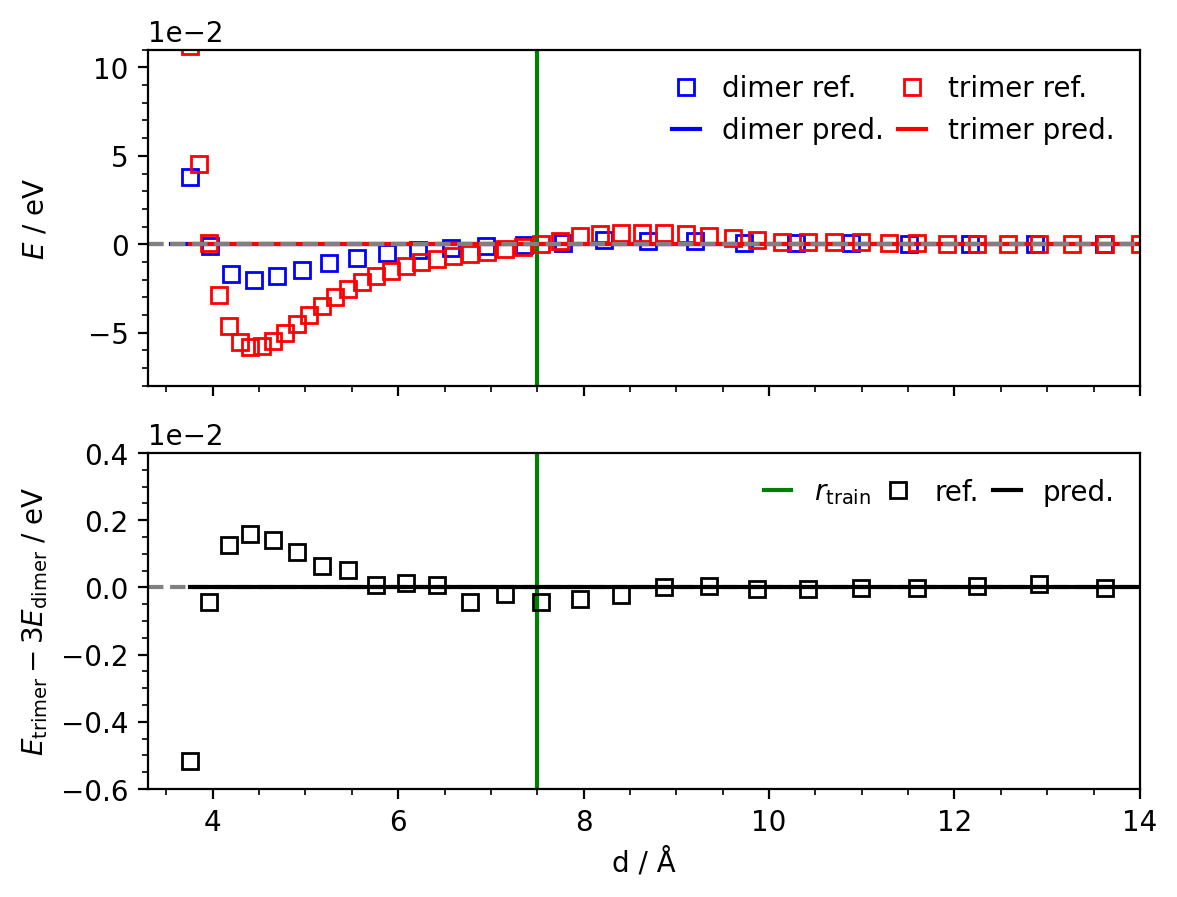

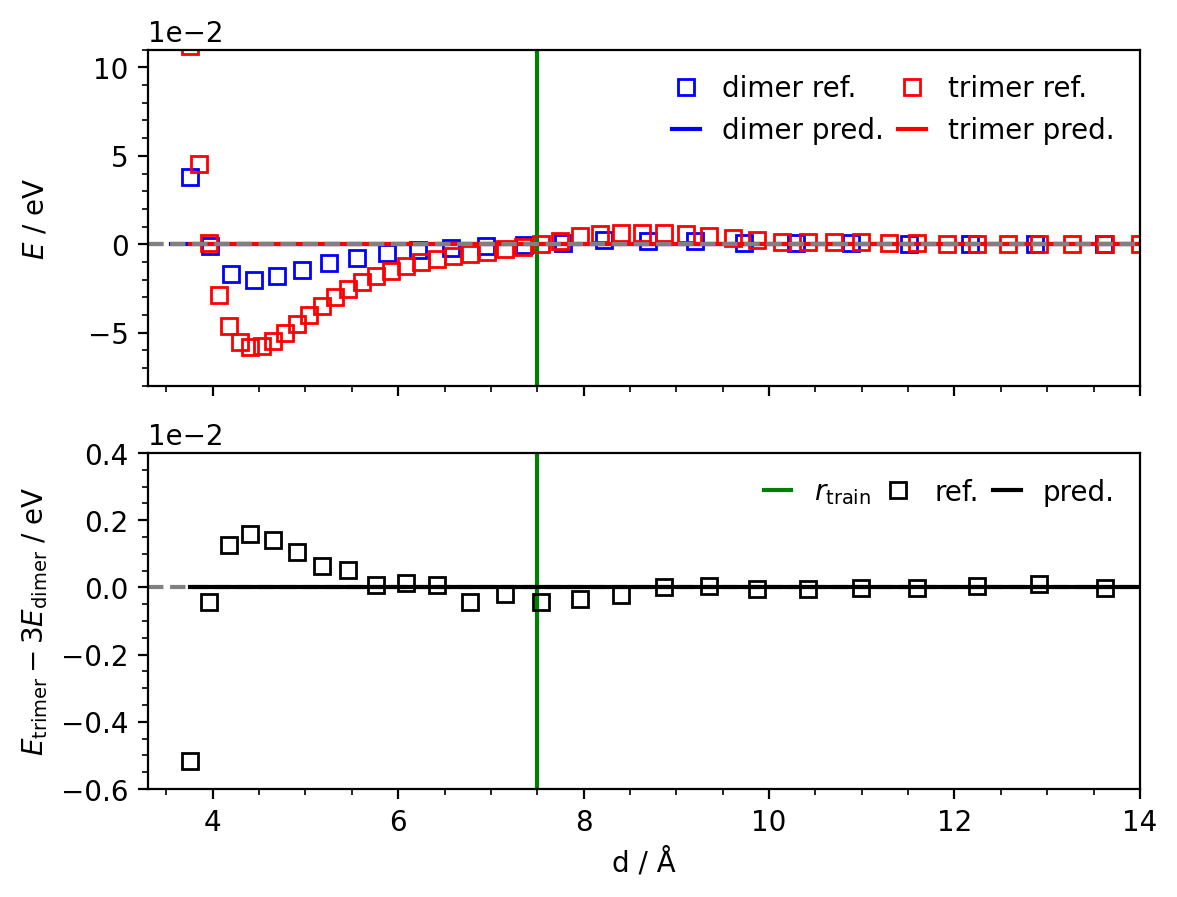

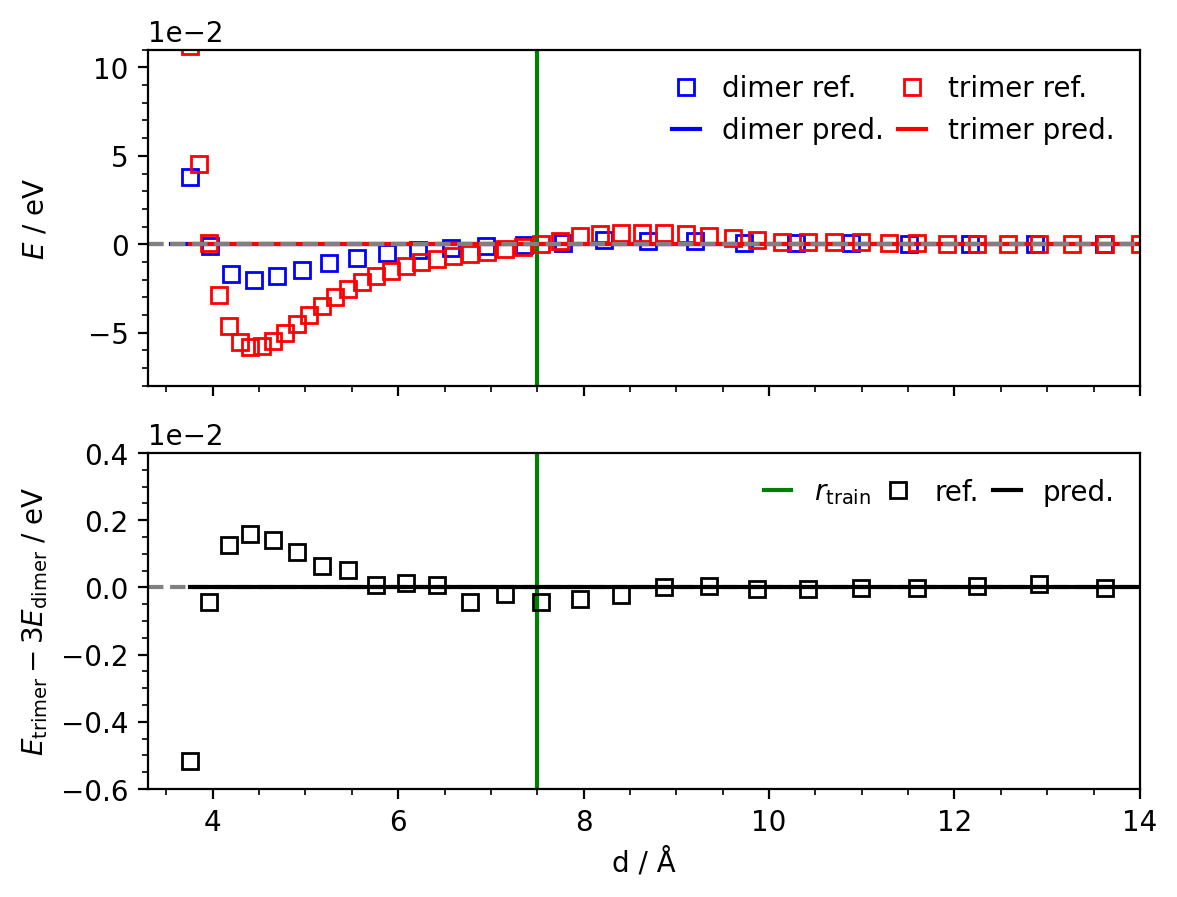

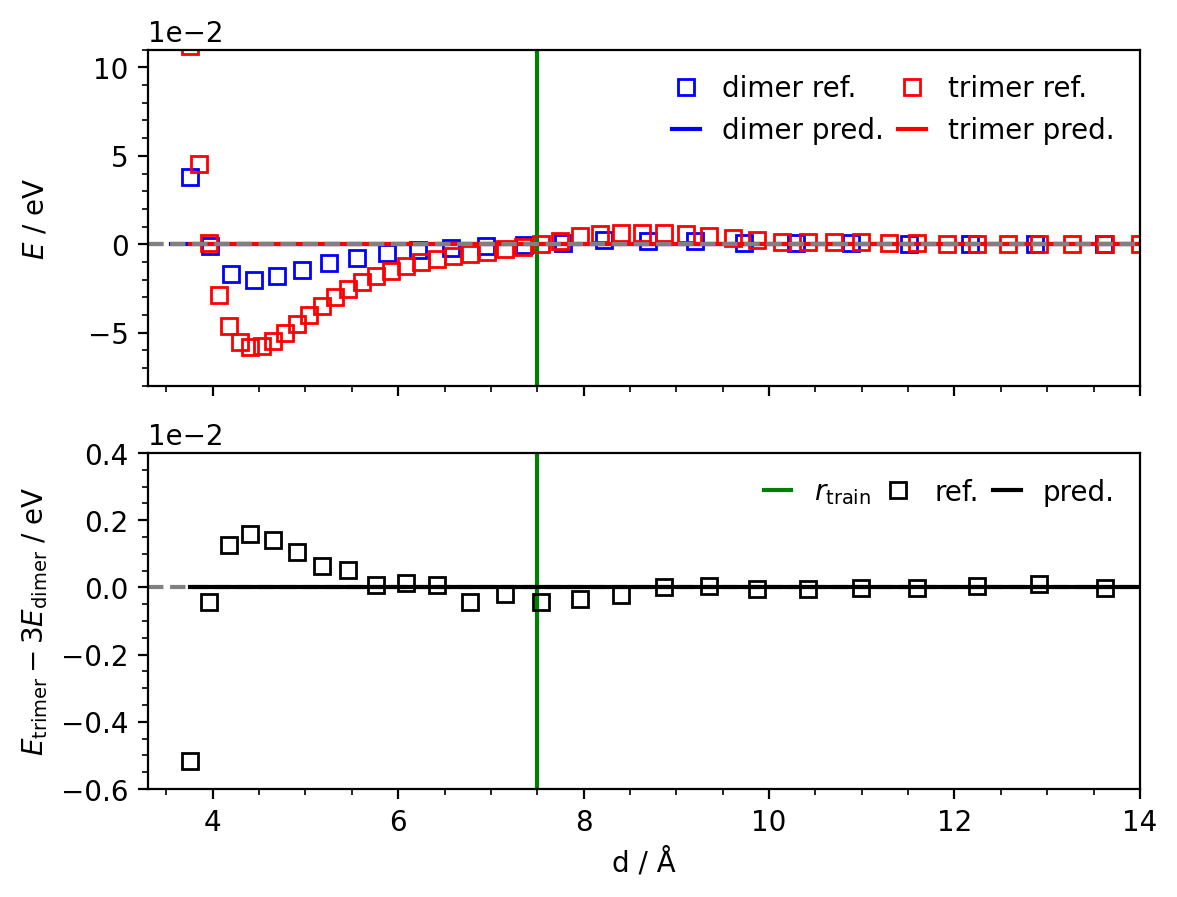

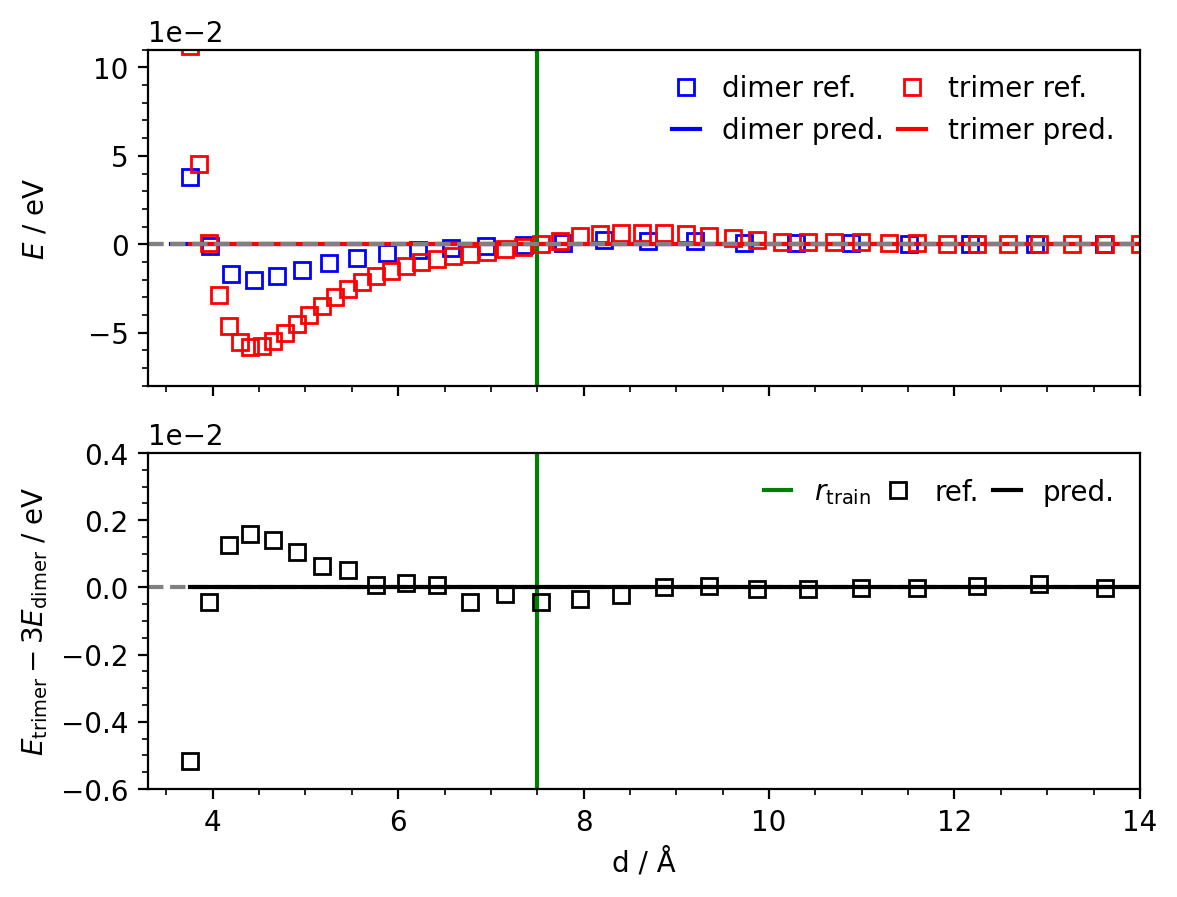

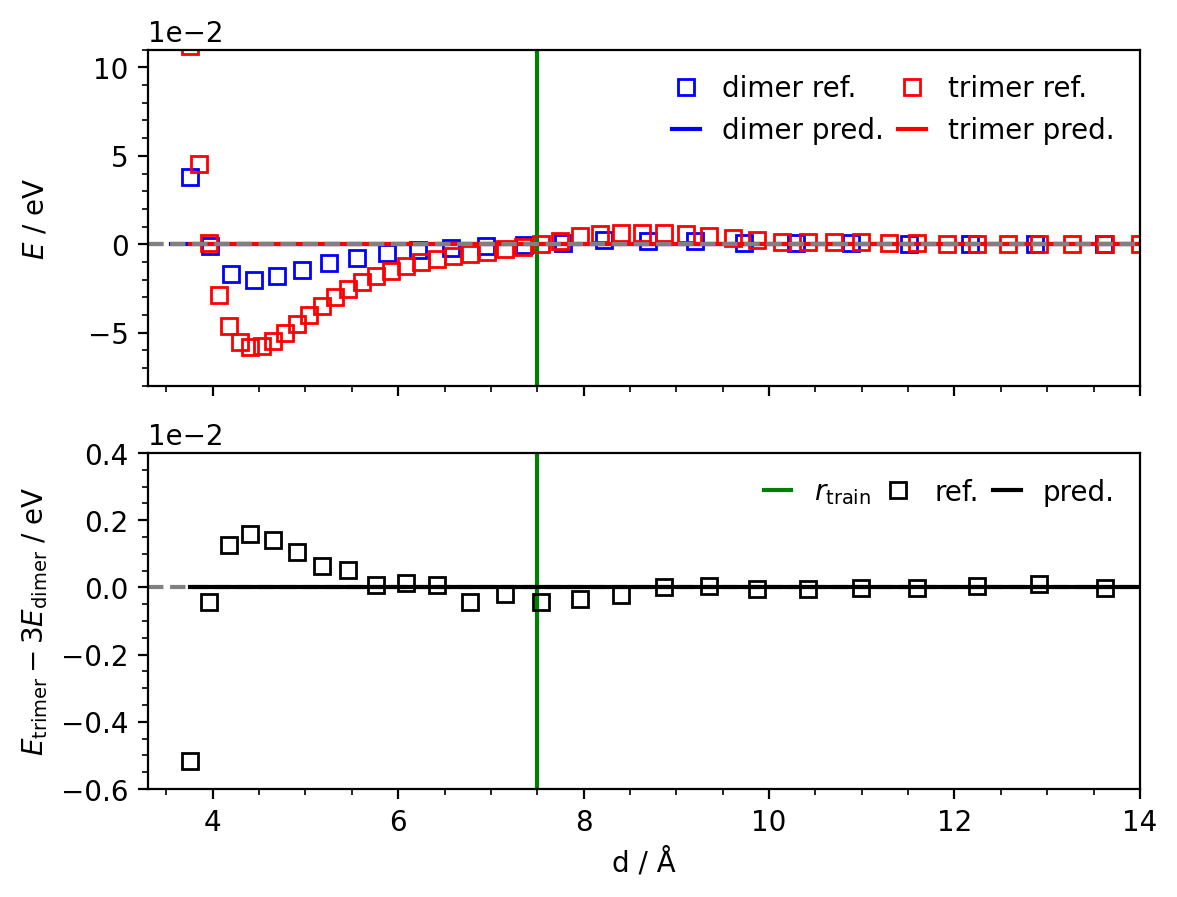

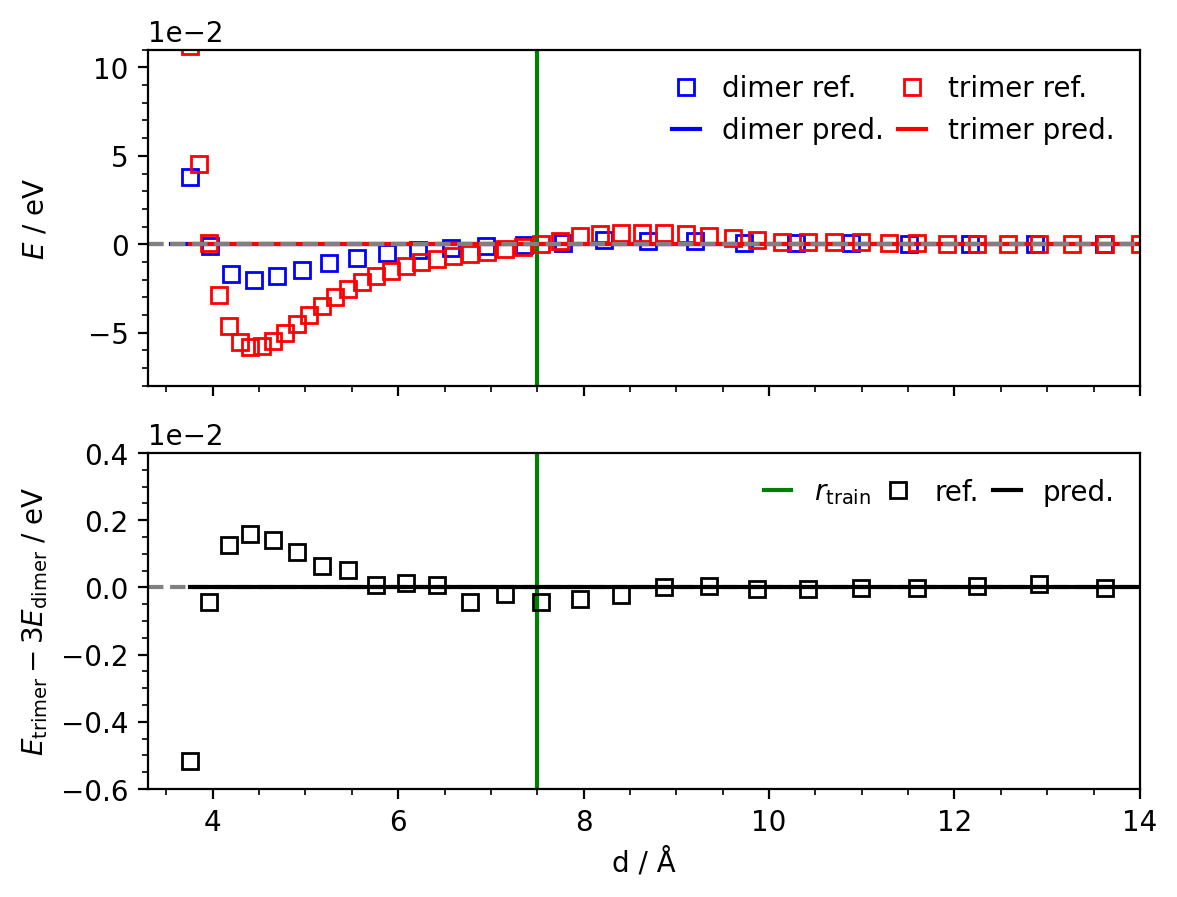

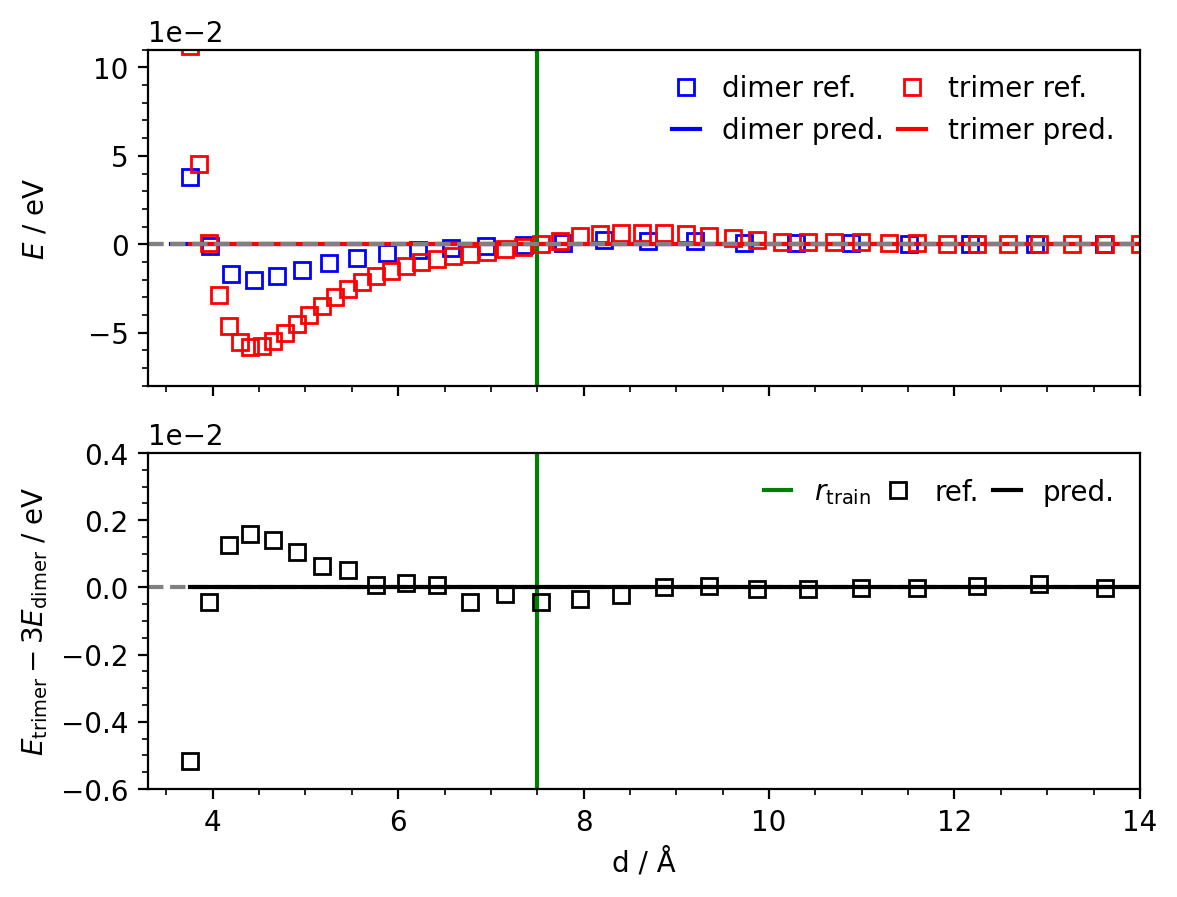

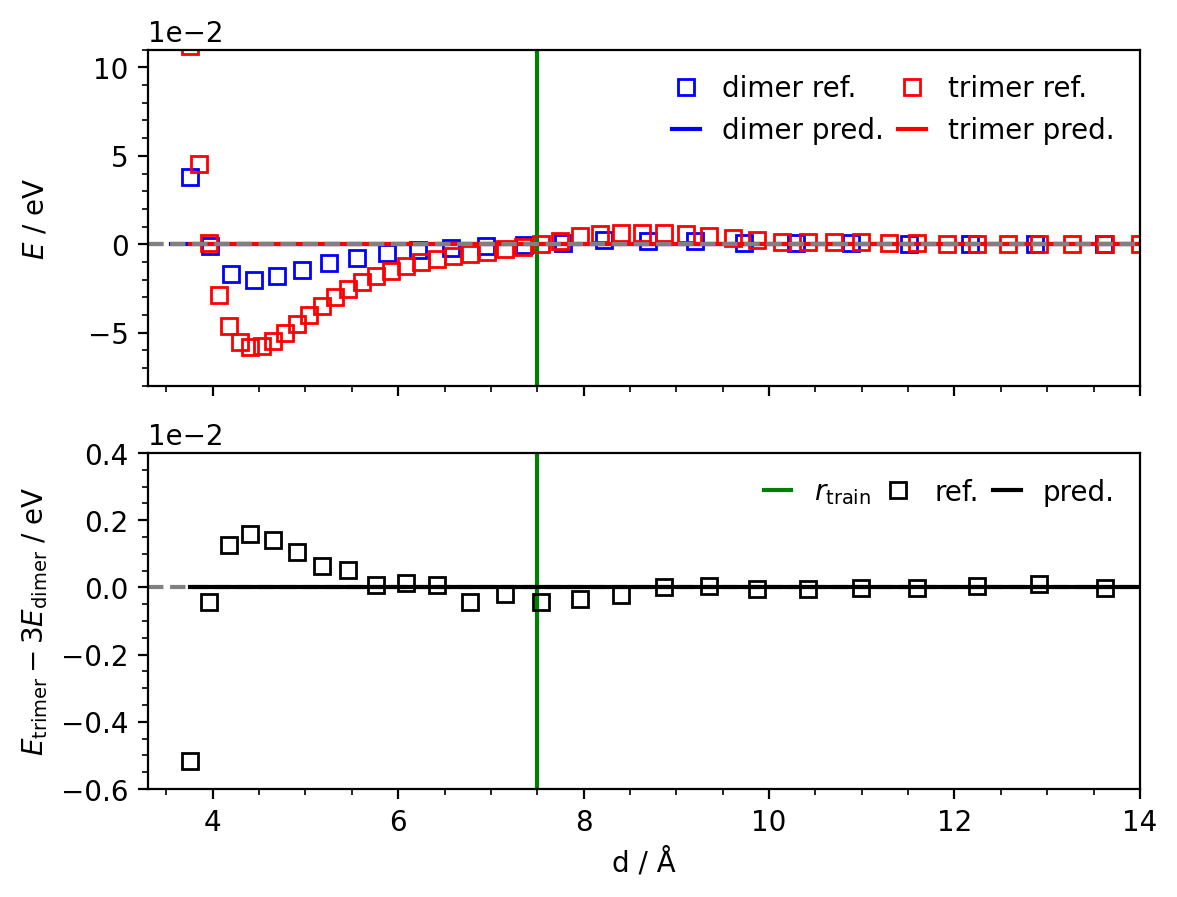

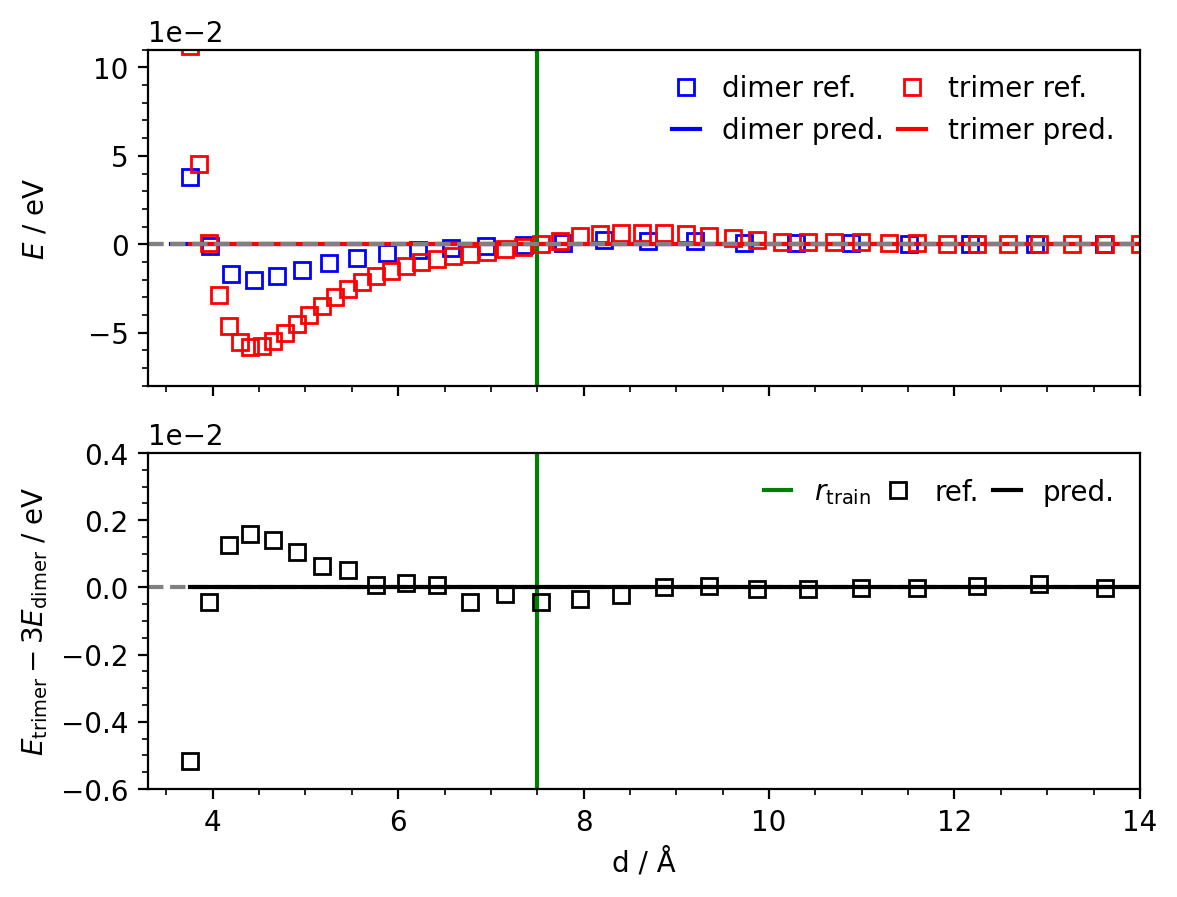

In [132]:
rmse_dimers = [] 
rmse_trimers =[]
rmse_diffs = []
for ratio in np.linspace(0.0, 1.0, 10, endpoint=False):
    n_random_trimer = int(n_total_random * ratio)
    random_trimer_idx = np.random.choice(list(range(100, 100 + len(random_trimer_datasets))), n_random_trimer, replace=False)
    mask = np.full(len(frames_datasets), False)
    mask[dimer_idx] = True
    mask[trimer_idx] = True
    mask[random_trimer_idx] = True
    train_frames_dataset, test_frames_dataset = get_train_test(mask)
    energies_random_trimers_dimers = calc_dimer_trimer_energies(
        random_trimer_datasets, dimer_energy_inter
    )
    energies_random_trimers_dimers -= diff_zero_point

    idx_train = np.array(train_frames_dataset)[np.newaxis, :].T
    idx_test = np.array(test_frames_dataset)[np.newaxis, :].T
    X_train, X_test, y_train, y_test = split(X, y, idx_train, idx_test)
    y_train[0].values[y_train[0].values > -600000] /= 2
    y_train[0].values[y_train[0].values < -600000] /= 3

    #y_diff = y[0].values.flatten() - yp_base
    #y_diff_train = y_diff[idx_train].flatten()

    clf = MLPRegressor(
        hidden_layer_sizes=(256, 128, 64, 32),
        activation='tanh',
        solver='adam',
        max_iter=30,
        verbose=True,
        learning_rate_init=1e3,
        learning_rate="adaptive",
        alpha=1e-20,
        n_iter_no_change=20
    )

    #clf = RidgeCV(alphas=np.geomspace(1e-9, 1e2, 32), fit_intercept=True)
    mean = y_train[0].values.mean()
    std = y_train[0].values.std()
    y_norm = (y_train[0].values - mean) / std
    #clf.fit(X_train[0].values, y_train[0].values.flatten() * 10)
    #clf.fit(X_train[0].values, y_diff_train)
    #clf.fit((X_train[0].values - np.mean(X_train[0].values, axis=0)) / np.std(X_train[0].values, axis=0), y_norm)
    clf.fit(X_train[0].values, y_train[0].values * 10)
    #print(clf.alpha_)
    

    y_diff_pred = clf.predict(X[0].values).flatten()
    y_pred = np.copy(y_diff_pred) / 10# * std + mean # + yp_base
    y_pred[:50] *= 2
    y_pred[50:] *= 3

    y_pred_dimers = y_pred[:50]
    y_pred_trimers = y_pred[50:]

    y_pred_inter = scipy.interpolate.CubicSpline(
        distances_dimers, y_pred_dimers, extrapolate=False
    )
    y_pred_dimers -= y_pred_dimers[-1]
    y_pred_trimers -= y_pred_trimers[49]
    y_dimer_trimer = calc_dimer_trimer_energies(frames_datasets[50:], y_pred_inter)
    y_dimer_trimer -= y_dimer_trimer[49]

    rmse_dimer = mean_squared_error(
        y_pred_dimers[np.array(test_frames_dataset)[:50 - n_dimer]], 
        energies_dimers[np.array(test_frames_dataset)[:50 - n_dimer]], squared=False
    ) / np.std(y_pred_dimers[train_frames_dataset[:n_dimer]])

    rmse_trimer = mean_squared_error(
        y_pred_trimers[np.array(test_frames_dataset)[50 - n_trimer:] - 50], 
        np.concatenate([energies_trimers, energies_random_trimers])[np.array(test_frames_dataset)[50 - n_trimer:] - 50], squared=False
    ) / np.std(np.concatenate([y_pred_dimers, y_pred_trimers])[train_frames_dataset])

    rmse_diff = mean_squared_error(
        np.concatenate([energies_trimers, energies_random_trimers])[test_frames_dataset[n_dimer:] - 50] - np.concatenate([energies_trimers_drimers, energies_random_trimers_dimers])[test_frames_dataset[n_dimer:] - 50], 
        y_pred_trimers[test_frames_dataset[n_dimer:] - 50] - y_dimer_trimer[test_frames_dataset[n_dimer:] - 50], squared=False
    ) / np.std((y_pred_trimers - y_dimer_trimer)[np.array(train_frames_dataset)[50 - n_dimer:] - 50])

    print(f'{ratio=} {rmse_dimer=} {rmse_trimer=} {rmse_diff=}')
    rmse_dimers.append(rmse_dimer)
    rmse_trimers.append(rmse_trimer)
    rmse_diffs.append(rmse_diff)

    plot(f"figures/xe_{outname_suffix}_{ratio}.pdf", show_trimer=True, subplotlabels=subplotlabels)

Text(0.5, 0, 'ratio of training non-equilateral trimers')

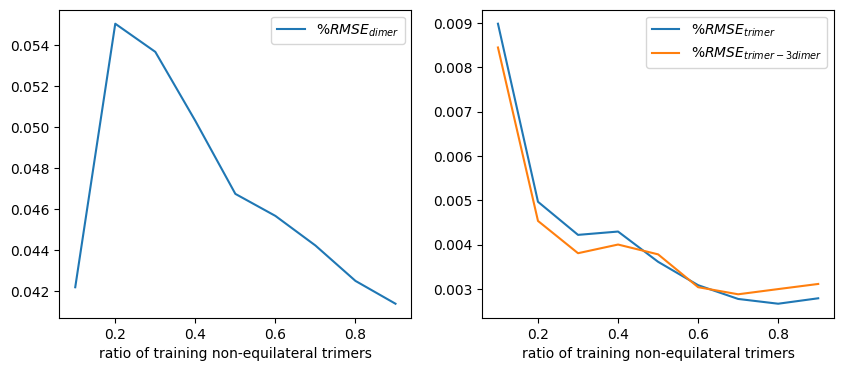

In [102]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].plot(np.linspace(0.0, 1.0, 10, endpoint=False)[1:], rmse_dimers[1:], label='$\%RMSE_{dimer}$')
ax[0].legend()
ax[0].set_xlabel('ratio of training non-equilateral trimers')
ax[1].plot(np.linspace(0.0, 1.0, 10, endpoint=False)[1:], rmse_trimers[1:], label='$\%RMSE_{trimer}$')
ax[1].plot(np.linspace(0.0, 1.0, 10, endpoint=False)[1:], rmse_diffs[1:], label='$\%RMSE_{trimer - 3dimer}$')
ax[1].legend()
ax[1].set_xlabel('ratio of training non-equilateral trimers')

In [76]:
import torch

ModuleNotFoundError: No module named 'torch'